Imports

In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os

Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Plot functions

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Class to manage configuration

In [4]:
class Config():
    training_dir = "images/training" #path to the training directory
    testing_dir =  "images/testing" #path to the testing directory
    train_batch_size = 64

Generates image pairs --> 0 for geniune pair and 1 for imposter pair

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir) #training dataset


Custom datasets

In [7]:
siamese_dataset_128x128_30 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)

siamese_dataset_32x32_30 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((32,32)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)

Train dataloaders

In [8]:
train_dataloader_128x128_30 = DataLoader(siamese_dataset_128x128_30,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

train_dataloader_32x32_30 = DataLoader(siamese_dataset_32x32_30,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

Visualization image pairs --> 1 indiciates dissimilar, and 0 indicates similar

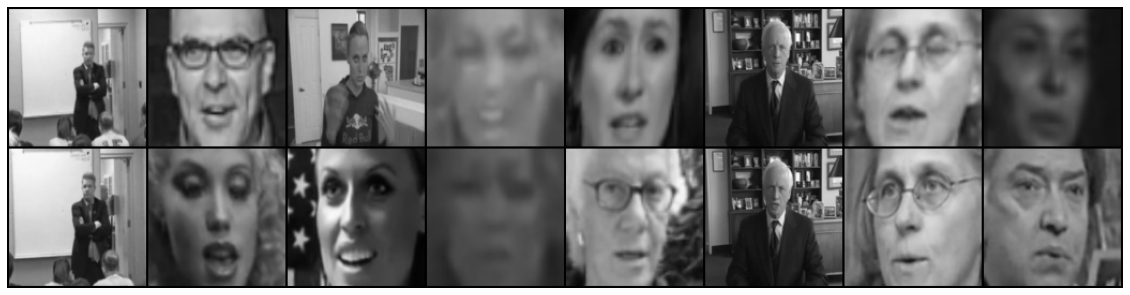

[0. 1. 0. 0. 1. 0. 0. 1.]


In [9]:
vis_dataloader = DataLoader(siamese_dataset_128x128_30,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8
)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.figure(figsize=[20, 20])
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Siamese models

In [10]:
class SiameseNetwork128x128(nn.Module):
    def __init__(self):
        super(SiameseNetwork128x128, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =43264, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

In [12]:
class SiameseNetwork32x32(nn.Module):
    def __init__(self):
        super(SiameseNetwork32x32, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =256, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

Loss function

In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

Train function

In [14]:
def train(device, siamese_model, epochs, optimizer, loss_function, train_dataloader, save):
    counter = []
    loss_history = [] 
    iteration_number= 0
    best_loss = 100
    for epoch in tqdm(range(0,epochs)):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data #data is 2 images and a label
            
            img0, img1 , label = img0.to(device), img1.to(device), label.to(device) #push to gpu
            
            optimizer.zero_grad() #zero gradients for every batch
            
            output1,output2 = siamese_model(img0,img1) #pass 2 images in the network and obtain two outputs
            
            loss = loss_function(output1,output2,label) #compute loss for both outputs and the label
            
            loss.backward() #compute gradients
            
            optimizer.step() #adjust learning weights
            
            if i %len(train_dataloader) == 0 : #gather data and report progress
                print("Epoch number {}: Current loss {}".format(epoch, loss.item()))
                if loss.item() < best_loss:
                    torch.save(siamese_model.state_dict(), save)
                    best_loss = loss.item()
                    
                iteration_number +=1
                counter.append(iteration_number)
                loss_history.append(loss.item())

    show_plot(counter,loss_history)

In [15]:
siamese_model128x128 = SiameseNetwork128x128().to(device)
siamese_model32x32 = SiameseNetwork32x32().to(device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 1.9896056652069092


  7%|▋         | 1/15 [01:41<23:43, 101.66s/it]

Epoch number 1: Current loss 0.8482283353805542


 13%|█▎        | 2/15 [03:15<21:01, 97.05s/it] 

Epoch number 2: Current loss 0.6881824731826782


 20%|██        | 3/15 [04:47<18:58, 94.91s/it]

Epoch number 3: Current loss 0.7908145189285278


 27%|██▋       | 4/15 [06:19<17:10, 93.70s/it]

Epoch number 4: Current loss 0.9853508472442627


 33%|███▎      | 5/15 [07:52<15:32, 93.27s/it]

Epoch number 5: Current loss 1.8124920129776


 40%|████      | 6/15 [09:24<13:55, 92.85s/it]

Epoch number 6: Current loss 1.812493085861206


 47%|████▋     | 7/15 [10:56<12:20, 92.57s/it]

Epoch number 7: Current loss 1.4999942779541016


 53%|█████▎    | 8/15 [12:25<10:41, 91.64s/it]

Epoch number 8: Current loss 2.2499914169311523


 60%|██████    | 9/15 [13:58<09:11, 91.96s/it]

Epoch number 9: Current loss 1.9999923706054688


 67%|██████▋   | 10/15 [15:29<07:38, 91.78s/it]

Epoch number 10: Current loss 2.374990940093994


 73%|███████▎  | 11/15 [17:02<06:07, 91.88s/it]

Epoch number 11: Current loss 2.1249918937683105


 80%|████████  | 12/15 [18:33<04:35, 91.84s/it]

Epoch number 12: Current loss 2.0624921321868896


 87%|████████▋ | 13/15 [20:05<03:03, 91.90s/it]

Epoch number 13: Current loss 1.9374926090240479


 93%|█████████▎| 14/15 [21:37<01:31, 91.93s/it]

Epoch number 14: Current loss 1.828118085861206


100%|██████████| 15/15 [23:08<00:00, 92.58s/it]


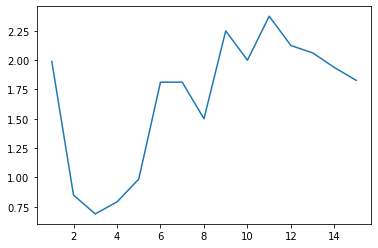

In [16]:
network128x128 = train(device, siamese_model128x128, 15, optim.Adam(siamese_model128x128.parameters()) , ContrastiveLoss(), train_dataloader_128x128_30, 'savepath/128x128.pth' )

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 1.8575984239578247


  7%|▋         | 1/15 [01:08<15:56, 68.31s/it]

Epoch number 1: Current loss 1.041170358657837


 13%|█▎        | 2/15 [02:16<14:46, 68.20s/it]

Epoch number 2: Current loss 1.0782990455627441


 20%|██        | 3/15 [03:24<13:36, 68.05s/it]

Epoch number 3: Current loss 0.8355035781860352


 27%|██▋       | 4/15 [04:32<12:29, 68.12s/it]

Epoch number 4: Current loss 0.972517728805542


 33%|███▎      | 5/15 [05:40<11:20, 68.06s/it]

Epoch number 5: Current loss 0.9603549242019653


 40%|████      | 6/15 [06:48<10:11, 67.96s/it]

Epoch number 6: Current loss 0.8267284035682678


 47%|████▋     | 7/15 [07:56<09:03, 67.90s/it]

Epoch number 7: Current loss 0.8474213480949402


 53%|█████▎    | 8/15 [09:03<07:55, 67.93s/it]

Epoch number 8: Current loss 0.8396130204200745


 60%|██████    | 9/15 [10:11<06:47, 67.93s/it]

Epoch number 9: Current loss 0.7863219976425171


 67%|██████▋   | 10/15 [11:20<05:40, 68.04s/it]

Epoch number 10: Current loss 0.7601568698883057


 73%|███████▎  | 11/15 [12:28<04:32, 68.05s/it]

Epoch number 11: Current loss 0.8676541447639465


 80%|████████  | 12/15 [13:37<03:24, 68.27s/it]

Epoch number 12: Current loss 0.6749873161315918


 87%|████████▋ | 13/15 [14:45<02:16, 68.23s/it]

Epoch number 13: Current loss 0.7591193318367004


 93%|█████████▎| 14/15 [15:53<01:08, 68.20s/it]

Epoch number 14: Current loss 0.8209490776062012


100%|██████████| 15/15 [17:01<00:00, 68.09s/it]


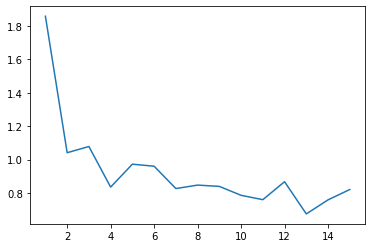

In [18]:
network32x32 = train(device, siamese_model32x32, 15, optim.Adam(siamese_model32x32.parameters()) , ContrastiveLoss(), train_dataloader_32x32_30, 'savepath/30Dlib/32x32.pth' )